# 이 노트북에서는: naive clustering
 - 고객의 기본 정보는 알 수 있지만 구매 내역이 부족한 경우, 비슷한 성향의 고객끼리 "군집화" 하면 소비 패턴을 어느 정도 예측해 볼 수 있다. 이를 위해 다음 작업을 수행한다.
 - PCA: 차원 축소
 - clustering(user demo. info. 이용)
    

### 0. about dataset: stanford marketing.
Attribute 설명 (요약)

- annual income, age등 14개의 고객 정보가 label encoding 되어 있다.
- 8993명의 고객 데이터로 구성되어 있고, 약간의 결측치가 포함되어 있다.

(https://web.stanford.edu/~hastie/ElemStatLearn//datasets/marketing.info.txt)



### 1. Data cleaning and EDA 
- 기초 통계량 확인
- 결측치 처리

#### import block

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [3]:
base_path = "/home/ssum/바탕화면/experiments/mall-customers/"

In [4]:
df_customer = pd.read_csv(base_path+ "sanfrancisco_customers.csv")

#### 데이터의 기초 통계량

In [5]:
df_customer.describe()

,Annual Income,Sex,Marital Status,Age,Education,Occupation,Years living in the area,Dual income,Persons in household,Persons in household < 18,Householder status,Type of home,Ethnic classification,Most spoken language
count,8993.000000,8993.000000,8833.000000,8993.000000,8907.000000,8857.000000,8080.000000,8993.000000,8618.000000,8993.000000,8753.000000,8636.000000,8925.000000,8634.000000
mean,4.895029,1.546870,3.031020,3.415212,3.835074,3.787964,4.198267,1.544757,2.851822,0.666852,1.836742,1.855720,5.955854,1.127519
std,2.773695,0.497826,1.809343,1.637581,1.242391,2.544717,1.226254,0.739565,1.535914,1.083886,0.744396,1.145279,1.757631,0.414411
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,2.000000,3.000000,1.000000,4.000000,1.000000,2.000000,0.000000,1.000000,1.000000,5.000000,1.000000
50%,5.000000,2.000000,3.000000,3.000000,4.000000,4.000000,5.000000,1.000000,3.000000,0.000000,2.000000,1.000000,7.000000,1.000000
75%,7.000000,2.000000,5.000000,4.000000,5.000000,6.000000,5.000000,2.000000,4.000000,1.000000,2.000000,3.000000,7.000000,1.000000
max,9.000000,2.000000,5.000000,7.000000,6.000000,9.000000,5.000000,3.000000,9.000000,9.000000,3.000000,5.000000,8.000000,3.000000


#### 결측치 처리: categorical variables= 최빈값으로 대체

In [6]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [7]:
# Missing values statistics
missing_values = missing_values_table(df_customer)
missing_values.head(20)

Your selected dataframe has 14 columns.
There are 9 columns that have missing values.


,Missing Values,% of Total Values
Years living in the area,913,10.2
Persons in household,375,4.2
Most spoken language,359,4.0
Type of home,357,4.0
Householder status,240,2.7
Marital Status,160,1.8
Occupation,136,1.5
Education,86,1.0
Ethnic classification,68,0.8


In [8]:
for col in missing_values.index:
    top_frq = df_customer[col].value_counts(dropna=True).idxmax()
    df_customer[col].fillna(top_frq, inplace=True)

##### 최빈값 대체 결과

In [9]:
missing_values = missing_values_table(df_customer)
missing_values.head(20)

Your selected dataframe has 14 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


### 2. clustering: K-Means
- scaling
- PCA

#### standard scaling

In [10]:
scaler = StandardScaler()
df_customer = pd.DataFrame(scaler.fit_transform(df_customer), columns=df_customer.columns)
df_customer.head()

/home/ssum/.local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ssum/.local/lib/python2.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,Annual Income,Sex,Marital Status,Age,Education,Occupation,Years living in the area,Dual income,Persons in household,Persons in household < 18,Householder status,Type of home,Ethnic classification,Most spoken language
0,1.480047,0.910269,-1.140289,0.967815,0.132109,0.492213,0.606741,1.967810,0.121407,-0.615276,-1.144624,-0.724251,0.591059,-0.300956
1,1.480047,-1.098577,-1.140289,0.967815,0.940863,0.492213,0.606741,1.967810,1.443219,1.230039,-1.144624,-0.724251,0.591059,-0.300956
2,1.480047,0.910269,-1.140289,-0.253566,0.940863,-1.077597,0.606741,0.615589,0.121407,0.307381,0.216244,1.038453,0.591059,-0.300956
3,-1.404353,0.910269,1.067379,-1.474947,-1.485397,0.884666,0.606741,-0.736632,0.782313,1.230039,1.577112,-0.724251,0.591059,-0.300956
4,-1.404353,0.910269,1.067379,-1.474947,-1.485397,0.884666,-1.077860,-0.736632,0.782313,1.230039,1.577112,-0.724251,0.591059,-0.300956


#### K-Means with dimensionality reduction
- PCA는 sklearn의 패키지를 사용해도 됨.
- 여기서는 covraiance matrix의 projection을 이용함

In [11]:
cov_mat = np.dot(df_customer.T, df_customer)
cov_mat.shape

(14, 14)

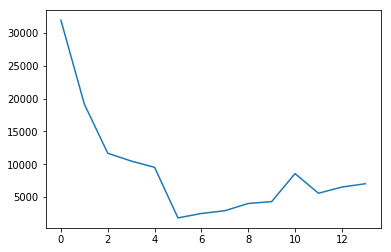

In [12]:
eigval, eigvec = np.linalg.eig(cov_mat)
plt.plot(eigval)

In [13]:
#projection to 2 dimensional eigen space
projected = pd.DataFrame(np.dot(df_customer, eigvec[:,:2]), columns=['pc1','pc2'])

In [14]:
model = KMeans(n_clusters=5,algorithm='auto')
model.fit(projected)
predict = pd.DataFrame(model.predict(projected))
predict.columns=['predict']


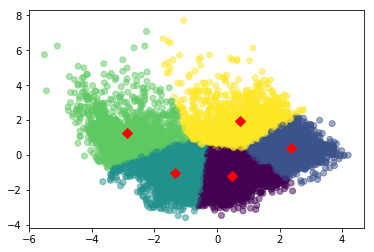

In [15]:
centers = pd.DataFrame(model.cluster_centers_,columns=['pc1','pc2'])
center_x = centers['pc1']
center_y = centers['pc2']

# scatter plot
plt.scatter(projected['pc1'],projected['pc2'],c=predict['predict'],alpha=0.5)
plt.scatter(center_x, center_y, s=50, marker='D', c='r')
plt.show()


#### k값 정하기: elbow method
- 위 scatter plot은 k=5 일 때.
- 적절한 k 값을 찾아야 함.

In [16]:
inertia = []
K = range(2,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(projected)
    inertia.append(kmeanModel.inertia_)

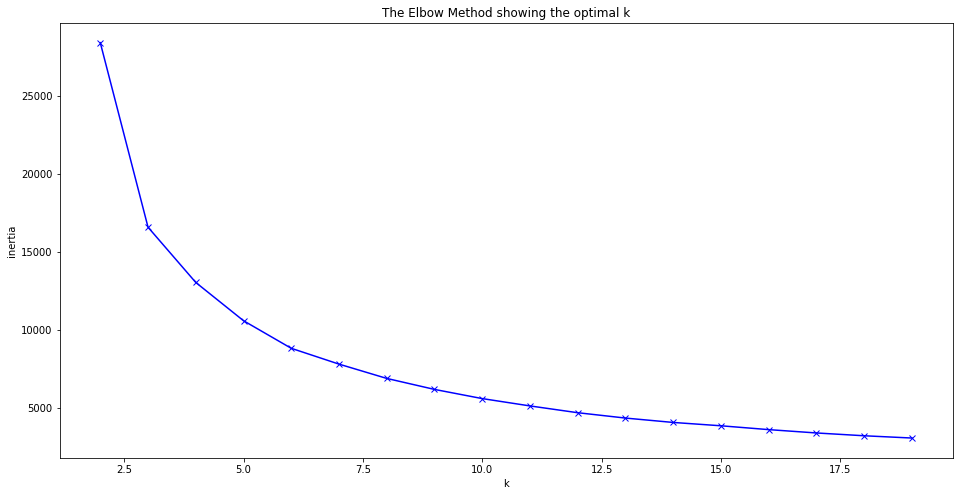

In [17]:
plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()

- k=5 일 때가 elbow로 보임.

## 결론
- 이 데이터셋의 고객들은 2 dimensional eigen space에서 5개의 군집으로 나뉘는 것을 알 수 있다. 
- 새로운 고객의 정보(14개 필드 값)가 주어진다면 이 새로운 고객이 5개의 군집 중 어디에 속하는지 알 수 있고, 각 군의 고객들 별로 상품을 추천할 수 있다.
- 다만, 이런 방식은 같은 고객군의 소비패턴이 유사하다는 가정 아래에서만 가능하다.
- (아래는 새로운 고객에 대해 위 5개의 군집 중 어디에 속하는지 반환해주는 함수)

In [18]:
def newbie_class(eigvec, centers, newbie):
    # projection
    projected = np.dot(newbie, eigvec[:,:2])
    return np.argmin(np.linalg.norm(centers - projected, axis=1))
    

- 예시: 고객 5명의 정보. standard scaled
- 만약 새로운 고객 정보에 결측치가 있다면, 최빈값으로 대체하면 된다

In [29]:
for i in range(5):
    newbie = df_customer.iloc[i]
    cls = newbie_class(eigvec, centers, newbie)
    print("a new customer is in : " + str(cls)+ " class")

a new customer is in : 1 class
a new customer is in : 4 class
a new customer is in : 1 class
a new customer is in : 3 class
a new customer is in : 3 class
